# Coding Exercise 4: Job Search with Separation and Stochastic Offers

## Question 1: Discrete and IID Wage Offers



### The model

An unemployed worker receives with a probability $0 < \gamma < 1$ a wage offer $ w_t $, where $ \{w_t\} $ is IID and is drawn from a publicly known probability distribution $ q(w) $ from a set finite set $\mathbb{W} $ at each point in time.

Once receiving an offer at time $ t $, the unemployed worker has two options:

1. Accept the offer and work at constant wage $ w_t $ until she gets laid off.
1. Reject the offer, receive unemployment compensation $ c $, and reconsider next period.

Each period an employed worker faces a probability $\alpha$ of getting laid off and becoming unemployed.

The agent is infinitely lived and aims to maximize the expected discounted sum of earnings

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t
$$

where
- $ \beta \in (0, 1) $ is the discount factor.
- $ y_t $ is income, equal to
    - his/her wage $ w_t $ when employed
    - unemployment compensation $ c $ when unemployed

Let's denote $ V(w) $ and $ U $ the value of being employed at wage $w$ and the value of being unemployed, respectively. Then

<a id='value_V'></a>
$$
V(w) = u(w) + \beta \Big[ (1-\alpha)V(w) + \alpha U \Big] \tag{1}
$$

and

<a id='value_U'></a>
$$
U = u(c) + \beta \left[(1-\gamma) U + \gamma \sum_{w' \in \mathbb W} \max\left\{V(w'), U\right\} q(w') \right] \tag{2}
$$


### Q.1-0: Import all external libraries that will used below.

- `numpy`, `numba`, `matplotlib` as usual
- `binom` from scipy.stats to generate wage offer distribution function in Q.1
- `brentq` from quantecon.optimize to solve the reservation wage in Q.2

라이브러리 패키지 에러가 발생해 정상적인 코드가 재실행시 수평선 혹은 아예 실행이 안되는 경우가 발생합니다.

In [1]:
# your code here
!pip install quantecon
!pip install interpolation

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, float64
from numba.experimental import jitclass
from scipy.stats import binom
from quantecon.optimize import brentq
from scipy.optimize import brentq
from interpolation import interp
from scipy.interpolate import interp1d
from scipy.optimize import minimize

%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 5.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1


### Q.1-1: Generate wage offer distribution

Suppose that the wage offers from a binomial distribution $B(n,p)$ with $n=50$ and $p=0.5$. Also assume that the set of possible wage offers has $n+1$ elements with the lowest wage is 10 and the highest wage is 40.

- Generate a vector `w` for wage offers and `q` for the probability for each wage offer.
- plot `q` against `w`.

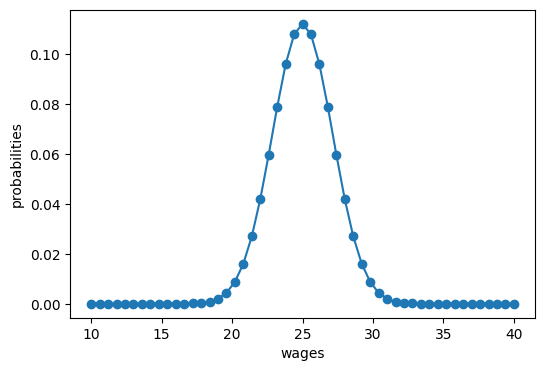

In [2]:
# your code here
n = 50       # Total number of trials
p = 0.5      # Probability of success
w_min = 10   # Minimum wage
w_max = 40   # Maximum wage

# Generating an array of wages from w_min to w_max with n+1 points
w = np.linspace(w_min, w_max, n+1)

# Calculating the binomial probability mass function (pmf) for each value in the range [0, n]
q = binom.pmf(range(n+1), n, p)

# Creating a new figure and axis
fig, ax = plt.subplots()

# Plotting the wages on the x-axis and the probabilities on the y-axis
ax.plot(w, q, '-o', label='$q(w(i))$')

# Setting the x-label and y-label
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

# Displaying the plot
plt.show()

### Q.1-2: Define the Class for the Model Economy

- specify types of the variables that are used in the class in `mccall_data`
- a function `__init__`: sets the default values for the data.
    - $\alpha = 0.1$: job separation rate
    - $\beta = 0.98$: discount factor
    - $\gamma = 0.7$: offer arrival rate
    - $\sigma = 2$: CRRA parameter
    - $c = 6$: unemployment compensation
- a function `u`: computes CRRA utility with parameter $\sigma$
- a function `update`: take V and U in the current as inputs and updates them according to equation (1) and (2)
- jit-compile the class with `@jitclass`


In [3]:
# your code here
mccall_data = [
    ('α', float64),      # Job separation rate
    ('β', float64),      # Discount factor
    ('γ', float64),      # Offer arrival rate
    ('σ', float64),      # CRRA parameter
    ('c', float64),       # Unemployment compensation
    ('w', float64[:]),    # List of wage values
    ('q', float64[:])]    # PMF of random variable w

@jitclass(mccall_data)
class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """
    def __init__(self,
                α = 0.1,    # Job separation rate
                β = 0.98,   # Discount rate
                γ = 0.7,    # Job offer rate
                c = 6.0,     # Unemployment compensation
                σ = 2.0,    # Utility parameter
                w = w,       # Possible wage values
                q = q):      # Probabilities over w_vec

        # Initializing the model parameters
        self.α, self.β, self.γ, self.c, self.σ, self.w, self.q = α, β, γ, c, σ, w, q

    def u(self, x):
        """
        Utility function.
        """
        return (x ** (1 - self.σ) - 1) / (1 - self.σ)

    def update(self, V, U):
        """
         A jitted function to update the Bellman equations.  Note that V_new is
         modified in place (i.e, modified by this function).  The new value of U
         is returned.
        """
        α, β, γ, c, w, q = self.α, self.β, self.γ, self.c, self.w, self.q
        u = self.u

        V_new = np.empty_like(V)   # To store updates to V

        # Calculating the new value function V_new for each wage value
        for i in range(len(w)):
            V_new[i] = u(w[i]) + β * ((1 - α) * V[i] + α * U)

        U_new = u(c) + β * ((1 - γ) * U + γ * np.sum((np.maximum(V, U) * q)))

        return V_new, U_new


### Q.1-3: Solve Value Functions through Iteration

- Write a function `solve_model` that iterates the value functions V and U until they converge to their fixed points.
- jit-compile the function with `@njit`
- Create an instance `mcm` of the class `McCallModel` with the default values.
- solve for the fixed points of V and U.
- plot the converged V and U.


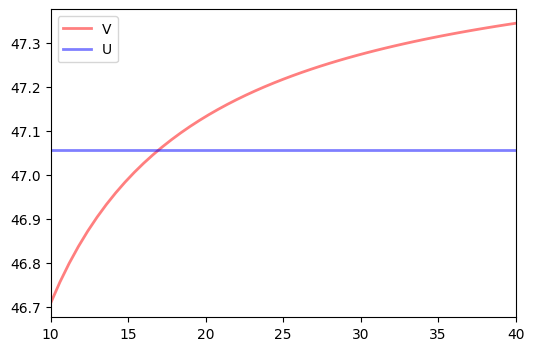

In [4]:
# your code here
@njit
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    Parameters
    ----------
    mcm : an instance of McCallModel
    tol : float
        error tolerance
    max_iter : int
        the maximum number of iterations
    """
    V = np.ones_like(mcm.w)    # Initial guess of V (value function)
    U = 1                      # Initial guess of U (reservation utility)
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        V_new, U_new = mcm.update(V, U)      # Updating V and U using the update method of McCallModel
        error_1 = np.max(np.abs(V_new - V))  # Calculating the maximum difference between new and old V
        error_2 = np.abs(U_new - U)          # Calculating the absolute difference between new and old U
        error = max(error_1, error_2)        # Taking the maximum of error_1 and error_2
        V = V_new                            # Updating V with V_new
        U = U_new                            # Updating U with U_new
        i += 1                               # Incrementing the iteration count

    return V, U


mcm = McCallModel()   # Creating an instance of McCallModel

V, U = solve_model(mcm)   # Solving the model and obtaining the value function V and reservation utility U

fig, ax = plt.subplots()

ax.plot(mcm.w, V, 'r-', lw=2, alpha=0.5, label='V')   # Plotting the value function V
ax.plot(mcm.w, [U] * len(mcm.w), 'b-', lw=2, alpha=0.5, label='U')   # Plotting the reservation utility U
ax.set_xlim(min(mcm.w), max(mcm.w))   # Setting the x-axis limits
ax.legend()   # Adding a legend to the plot

plt.show()

### Q.1-4: Reservation Wage

- Write a function `compute_reservation_wage` to compute the reservation wage for the model economy.
- jit-compile the class with `@njit`
- execute the function to show the reservation wage.

In [5]:
# your code here
@njit
def compute_reservation_wage(mcm):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that V(w) > U.

    If V(w) > U for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vec.

    If v(w) < U for all w, then w_bar is set to np.inf.

    Parameters
    ----------
    mcm : an instance of McCallModel
    return_values : bool (optional, default=False)
        Return the value functions as well

    Returns
    -------
    w_bar : scalar
        The reservation wage
    """
    V, U = solve_model(mcm)   # Solving the model and obtaining the value function V and reservation utility U

    w_bar = None   # Initializing the reservation wage as positive infinity
    for i, wage in enumerate(mcm.w):
        if V[i] > U:
            w_bar = wage   # Updating w_bar to the current wage if V(wage) > U
            break
    return w_bar

result_rw = compute_reservation_wage(mcm) # Computing and returning the reservation wage using the compute_reservation_wage function
print(f'reservation wage: {result_rw}')

reservation wage: 17.2


### Q.1-5: Unemployment Rate in the Steady State

The steady state of the labor market in the model economy is the situation where flows between employment and unemployment are equal. Assuming the size of labor force being one, the inflow to unemployment is $\alpha (1-u)$ and outflow from unemployment is $f u$, where $f = \sum_{q\ge \bar w} q(w)$ is the job finding rate for an unemployed worker. Hence the unemployment rate in the steady state is:
$$
u^* = \frac{\alpha}{\alpha + f}
$$

- write a function `steady_state_unemployment` to compute the unemployment rate in the steady state.
- jit compile the function with `@njit`
- execute the function to show the the unemployment rate in the steady state.

In [6]:
# your code here
@njit
def steady_state_unemployment(mcm):
    """
    Finds the steady state of the system :math:`x_{t+1} = \hat A x_{t}`

    Returns
    --------
    xbar : steady state vector of employment and unemployment rates
    """
    w_bar = compute_reservation_wage(mcm)   # Computing the reservation wage using the compute_reservation_wage function

    # Calculating the steady state unemployment rate
    f = mcm.γ * np.sum(mcm.q[mcm.w > w_bar])   # Summing the probabilities of wages greater than the reservation wage multiplied by the offer arrival rate
    u_star = mcm.α / (mcm.α + f)   # Calculating the steady state unemployment rate
    return u_star

result_ur = steady_state_unemployment(mcm)   # Computing and returning the steady state unemployment rate using the steady_state_unemployment function
print(f'unemployment rate: {result_ur}')

unemployment rate: 0.12501672917621084


### Q.1-6: Average Unemployment Duration

- write a function `compute_average_unemployment_duration` to compute the average unemployment duration of 10,000 unemployed workers.
- the functioin should include functions `compute_stopping_time` to compute the unemployment duration of an unemployed worker and `compute_mean_stopping_time(num_reps=10000)` to simulate 10,000 unemployed workers.
- jit compile the inside functions with `@njit` and `@njit(parallel=True)`.
- execute the function to show the the average unemployment duration.


In [7]:
# your code here
def compute_average_unemployment_duration(mcm, seed=1234):
    cdf = np.cumsum(mcm.q)   # Calculating the cumulative distribution function (CDF) of the wage probabilities
    w_bar = compute_reservation_wage(mcm)   # Computing the reservation wage using the compute_reservation_wage function
    w_default = mcm.w   # Storing the wage values in w_default
    np.random.seed(seed)   # Setting the seed for reproducibility

    @njit
    def compute_stopping_time():
        t = 1
        while True:
            w = w_default[qe.random.draw(cdf)]   # Drawing a random wage value using the CDF
            if w >= w_bar:
                stopping_time = t   # If the drawn wage is greater than or equal to the reservation wage, store the stopping time
                break
            else:
                t += 1   # If the drawn wage is less than the reservation wage, increment the stopping time and continue the loop
        return stopping_time

    @njit(parallel=True)
    def compute_mean_stopping_time(num_reps=10000):
        obs = np.empty(num_reps)
        for i in range(num_reps):
            obs[i] = compute_stopping_time()   # Computing the stopping time for each repetition and storing it in obs
        return obs.mean()   # Returning the mean of the stopping times

    return compute_mean_stopping_time()

result_aud = compute_average_unemployment_duration(mcm)   # Computing and returning the average unemployment duration using the compute_average_unemployment_duration function
print(f'average unemployment duration: {result_aud}')

average unemployment duration: 1.0


using the above codes that you wrote, compute the reservation wage, steady state unemployment rate, average unemployment duration for the model.

In [8]:
result_rw = compute_reservation_wage(mcm)   # Computing the reservation wage using the compute_reservation_wage function

result_ur = steady_state_unemployment(mcm)   # Computing the steady state unemployment rate using the steady_state_unemployment function

result_aud = compute_average_unemployment_duration(mcm)   # Computing the average unemployment duration using the compute_average_unemployment_duration function

# Printing the results
print(f'''reservation wage: {result_rw}''')
print(f'''unemployment rate at steady state: {result_ur}''')
print(f'''average unemployment duration: {result_aud}''')

reservation wage: 17.2
unemployment rate at steady state: 0.12501672917621084
average unemployment duration: 1.0


### Q.1-7: Comparative Statics: Reservation Wage

Show how reservation wages change as the model parameters change.

- Use the values for parameters below.
- compute reservation wages and plot the results

In [9]:
grid_size = 25

α_vals = np.linspace(0.01, 0.8, grid_size)
γ_vals = np.linspace(0.4, 0.99, grid_size)
σ_vals = np.linspace(0.5, 3.0, grid_size)
wmax_vals = np.linspace(20, 60, grid_size)
c_vals = np.linspace(5, 20, grid_size)
p_vals = np.linspace(0.1, 0.9, grid_size)


# your code here
mcm = McCallModel()
cdf = np.cumsum(q)

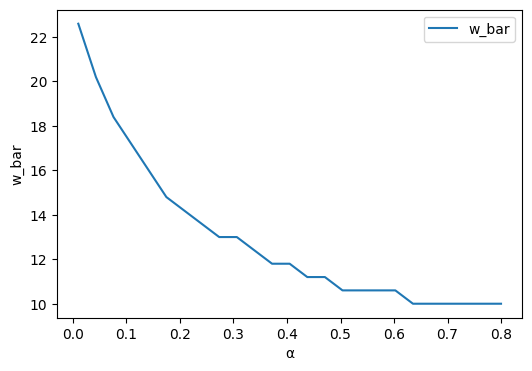

In [10]:
w_bar_vals = np.empty_like(α_vals)   # Array to store the computed reservation wages for each α value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each α value
for i, α in enumerate(α_vals):
    mcm.α = α   # Updating the α value in the McCallModel instance
    w_bar = compute_reservation_wage(mcm)   # Computing the reservation wage using the compute_reservation_wage function
    w_bar_vals[i] = w_bar   # Storing the computed reservation wage in the array

ax.plot(α_vals, w_bar_vals, label="w_bar")   # Plotting α values against reservation wages
ax.set(xlabel=f"α", ylabel="w_bar")   # Setting x and y labels for the plot
ax.legend()   # Adding a legend to the plot

mcm.α = 0.1   # Resetting the α value in the McCallModel instance

plt.show()   # Displaying the plot

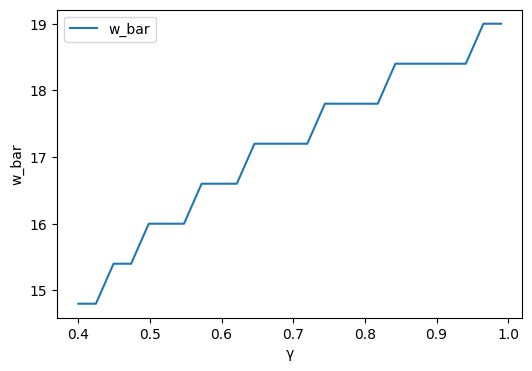

In [11]:
w_bar_vals = np.empty_like(γ_vals)   # Array to store the computed reservation wages for each γ value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each γ value
for i, γ in enumerate(γ_vals):
    mcm.γ = γ   # Updating the γ value in the McCallModel instance
    w_bar = compute_reservation_wage(mcm)   # Computing the reservation wage using the compute_reservation_wage function
    w_bar_vals[i] = w_bar   # Storing the computed reservation wage in the array

ax.plot(γ_vals, w_bar_vals, label="w_bar")   # Plotting γ values against reservation wages
ax.set(xlabel=f"γ", ylabel="w_bar")   # Setting x and y labels for the plot
ax.legend()   # Adding a legend to the plot

mcm.γ = 0.7   # Resetting the γ value in the McCallModel instance

plt.show()   # Displaying the plot

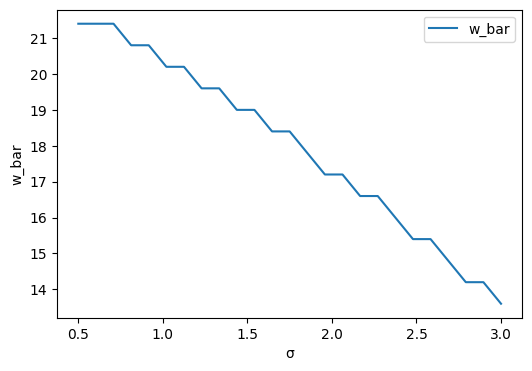

In [12]:
w_bar_vals = np.empty_like(σ_vals)   # Array to store the computed reservation wages for each σ value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each σ value
for i, σ in enumerate(σ_vals):
    mcm.σ = σ   # Updating the σ value in the McCallModel instance
    w_bar = compute_reservation_wage(mcm)   # Computing the reservation wage using the compute_reservation_wage function
    w_bar_vals[i] = w_bar   # Storing the computed reservation wage in the array

ax.plot(σ_vals, w_bar_vals, label="w_bar")   # Plotting σ values against reservation wages
ax.set(xlabel=f"σ", ylabel="w_bar")   # Setting x and y labels for the plot
ax.legend()   # Adding a legend to the plot

mcm.σ = 2.0   # Resetting the σ value in the McCallModel instance

plt.show()   # Displaying the plot

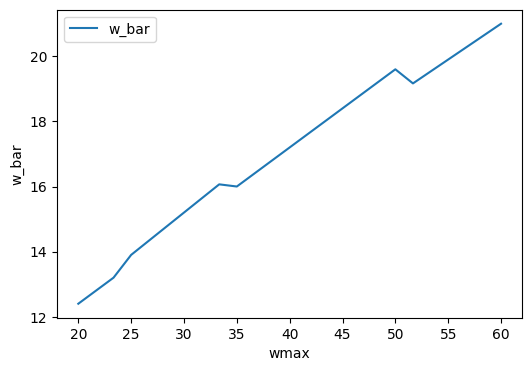

In [13]:
w_bar_vals = np.empty_like(wmax_vals)   # Array to store the computed reservation wages for each wmax value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each wmax value
for i, wmax in enumerate(wmax_vals):
    mcm.w = np.linspace(10, wmax, n+1)   # Updating the wage grid in the McCallModel instance
    w_bar = compute_reservation_wage(mcm)   # Computing the reservation wage using the compute_reservation_wage function
    w_bar_vals[i] = w_bar   # Storing the computed reservation wage in the array

ax.plot(wmax_vals, w_bar_vals, label="w_bar")   # Plotting wmax values against reservation wages
ax.set(xlabel=f"wmax", ylabel="w_bar")   # Setting x and y labels for the plot
ax.legend()   # Adding a legend to the plot

mcm.w = np.linspace(10, 40, n+1)   # Resetting the wage grid in the McCallModel instance

plt.show()   # Displaying the plot

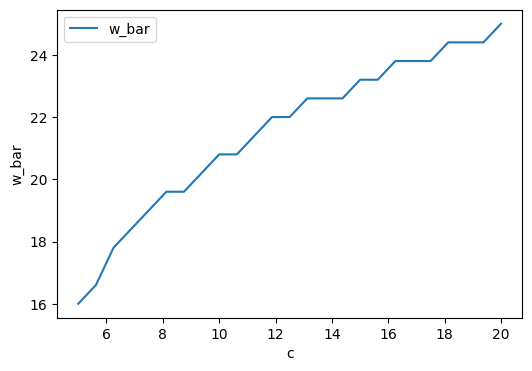

In [14]:
w_bar_vals = np.empty_like(c_vals)   # Array to store the computed reservation wages for each c value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each c value
for i, c in enumerate(c_vals):
    mcm.c = c   # Updating the c value in the McCallModel instance
    w_bar = compute_reservation_wage(mcm)   # Computing the reservation wage using the compute_reservation_wage function
    w_bar_vals[i] = w_bar   # Storing the computed reservation wage in the array

ax.plot(c_vals, w_bar_vals, label="w_bar")   # Plotting c values against reservation wages
ax.set(xlabel=f"c", ylabel="w_bar")   # Setting x and y labels for the plot
ax.legend()   # Adding a legend to the plot

mcm.c = 6   # Resetting the c value in the McCallModel instance

plt.show()   # Displaying the plot

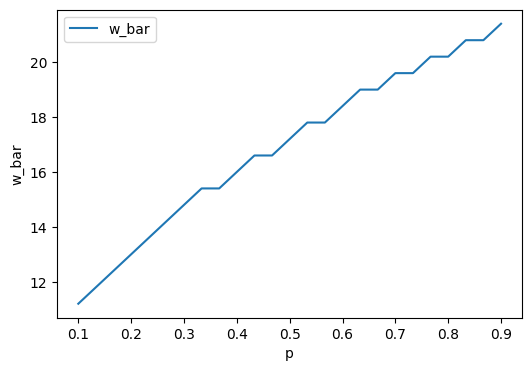

In [15]:
w_bar_vals = np.empty_like(p_vals)   # Array to store the computed reservation wages for each p value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each p value
for i, p in enumerate(p_vals):
    mcm.q = binom.pmf(range(n+1), n, p)   # Updating the q values in the McCallModel instance using binomial distribution
    w_bar = compute_reservation_wage(mcm)   # Computing the reservation wage using the compute_reservation_wage function
    w_bar_vals[i] = w_bar   # Storing the computed reservation wage in the array

ax.plot(p_vals, w_bar_vals, label="w_bar")   # Plotting p values against reservation wages
ax.set(xlabel=f"p", ylabel="w_bar")   # Setting x and y labels for the plot
ax.legend()   # Adding a legend to the plot

mcm.q = binom.pmf(range(n+1), n, 0.5)   # Resetting the q values in the McCallModel instance using binomial distribution

plt.show()   # Displaying the plot

### Q.1-8: Unemployment Rate in the Steady State

Show how the steady state unemployment rates change as the model parameters change.

- Use the values for parameters as in Q.1-7.
- compute steady state unemployment rates and plot the results

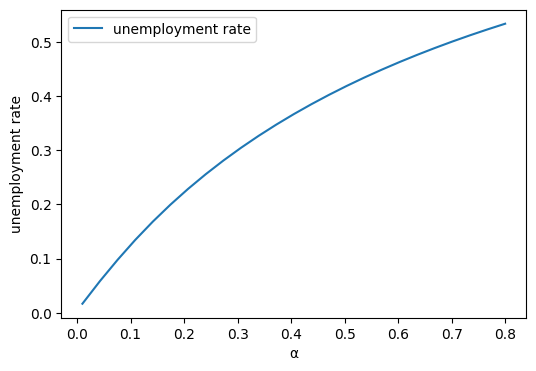

In [16]:
# your code here
ssu_vals = np.empty_like(α_vals)   # Array to store the computed steady-state unemployment rates for each α value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each α value
for i, α in enumerate(α_vals):
    mcm.α = α   # Updating the α value in the McCallModel instance
    ssu = steady_state_unemployment(mcm)   # Computing the steady-state unemployment rate using the steady_state_unemployment function
    ssu_vals[i] = ssu   # Storing the computed steady-state unemployment rate in the array

ax.plot(α_vals, ssu_vals, label="unemployment rate")   # Plotting α values against steady-state unemployment rates
ax.set(xlabel="α", ylabel="unemployment rate")   # Setting x and y labels for the plot
ax.legend()   # Adding a legend to the plot

mcm.α = 0.1   # Resetting the α value in the McCallModel instance

plt.show()   # Displaying the plot

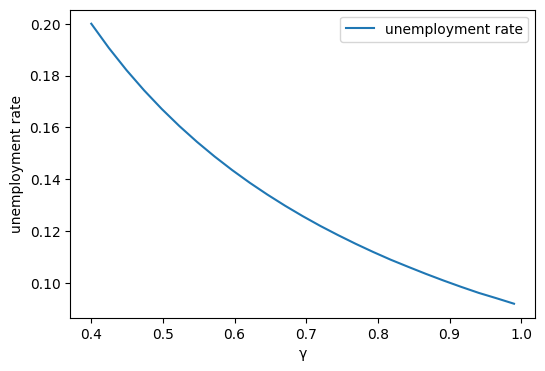

In [17]:
ssu_vals = np.empty_like(γ_vals)   # Array to store the computed steady-state unemployment rates for each γ value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each γ value
for i, γ in enumerate(γ_vals):
    mcm.γ = γ   # Updating the γ value in the McCallModel instance
    ssu = steady_state_unemployment(mcm)   # Computing the steady-state unemployment rate using the steady_state_unemployment function
    ssu_vals[i] = ssu   # Storing the computed steady-state unemployment rate in the array

ax.plot(γ_vals, ssu_vals, label="unemployment rate")   # Plotting γ values against steady-state unemployment rates
ax.set(xlabel="γ", ylabel="unemployment rate")   # Setting x and y labels for the plot
ax.legend()   # Adding a legend to the plot

mcm.γ = 0.7   # Resetting the γ value in the McCallModel instance

plt.show()   # Displaying the plot

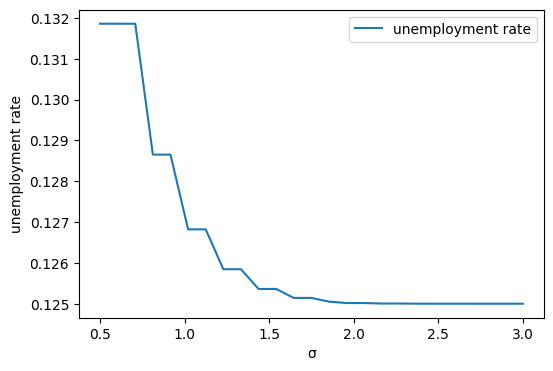

In [18]:
ssu_vals = np.empty_like(σ_vals)  # Create an empty array to store the unemployment rate values.

fig, ax = plt.subplots()  # Create a figure and axes to plot the graph.

for i, σ in enumerate(σ_vals):
    mcm.σ = σ  # Set the current value of σ as the σ value of the McCall model.
    ssu = steady_state_unemployment(mcm)  # Calculate the unemployment rate for the current McCall model configuration.
    ssu_vals[i] = ssu  # Store the calculated unemployment rate value in the ssu_vals array.

ax.plot(σ_vals, ssu_vals, label="unemployment rate")  # Plot the unemployment rate graph using σ_vals and ssu_vals.
ax.set(xlabel="σ", ylabel="unemployment rate")  # Set the labels for the x-axis and y-axis.
ax.legend()  # Display the legend.

mcm.σ = 2.0  # Set σ value back to its original value for further analysis or plotting.

plt.show()  # Display the plotted graph.

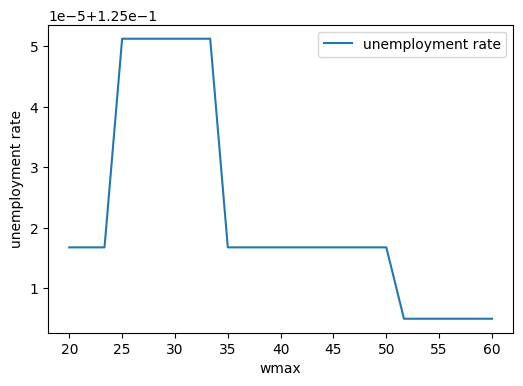

In [19]:
ssu_vals = np.empty_like(wmax_vals)  # Create an empty array to store the unemployment rate values.

fig, ax = plt.subplots()  # Create a figure and axes to plot the graph.

for i, wmax in enumerate(wmax_vals):
    mcm.w = np.linspace(10, wmax, n+1)  # Generate an array of wage values ranging from 10 to wmax.
    ssu = steady_state_unemployment(mcm)  # Calculate the unemployment rate for the current McCall model configuration.
    ssu_vals[i] = ssu  # Store the calculated unemployment rate value in the ssu_vals array.

ax.plot(wmax_vals, ssu_vals, label="unemployment rate")  # Plot the unemployment rate graph using wmax_vals and ssu_vals.
ax.set(xlabel="wmax", ylabel="unemployment rate")  # Set the labels for the x-axis and y-axis.
ax.legend()  # Display the legend.

mcm.w = np.linspace(10, 40, n+1)  # Reset the wage values back to the original range.

plt.show()  # Display the plotted graph.

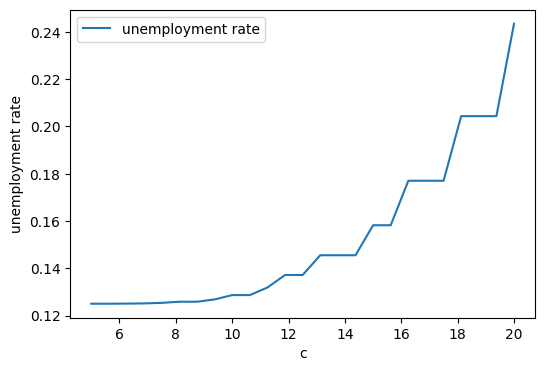

In [20]:
ssu_vals = np.empty_like(c_vals)  # Create an empty array to store the unemployment rate values.

fig, ax = plt.subplots()  # Create a figure and axes to plot the graph.

for i, c in enumerate(c_vals):
    mcm.c = c  # Set the current value of c as the c value of the McCall model.
    ssu = steady_state_unemployment(mcm)  # Calculate the unemployment rate for the current McCall model configuration.
    ssu_vals[i] = ssu  # Store the calculated unemployment rate value in the ssu_vals array.

ax.plot(c_vals, ssu_vals, label="unemployment rate")  # Plot the unemployment rate graph using c_vals and ssu_vals.
ax.set(xlabel="c", ylabel="unemployment rate")  # Set the labels for the x-axis and y-axis.
ax.legend()  # Display the legend.

mcm.c = 6  # Set c value back to its original value for further analysis or plotting.

plt.show()  # Display the plotted graph.

라이브러리 패키지 오류가 발생합니다.

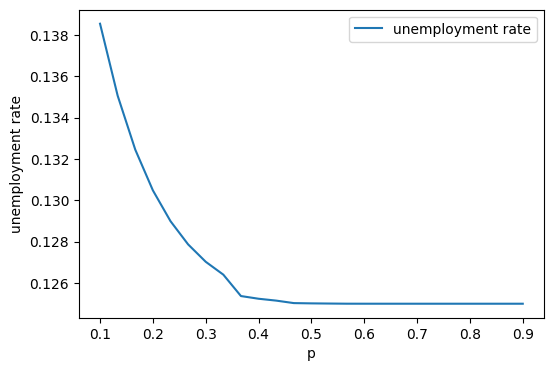

In [21]:
ssu_vals = np.empty_like(p_vals)  # Create an empty array to store the unemployment rate values.

fig, ax = plt.subplots()  # Create a figure and axes to plot the graph.

for i, p in enumerate(p_vals):
    mcm.q = binom.pmf(range(n+1), n, p)  # Set the q values based on the binomial distribution with parameters n and p.
    ssu = steady_state_unemployment(mcm)  # Calculate the unemployment rate for the current McCall model configuration.
    ssu_vals[i] = ssu  # Store the calculated unemployment rate value in the ssu_vals array.

ax.plot(p_vals, ssu_vals, label="unemployment rate")  # Plot the unemployment rate graph using p_vals and ssu_vals.
ax.set(xlabel="p", ylabel="unemployment rate")  # Set the labels for the x-axis and y-axis.
ax.legend()  # Display the legend.

mcm.q = binom.pmf(range(n+1), n, 0.5)  # Set q values back to its original values for further analysis or plotting.

plt.show()  # Display the plotted graph.

### Q.1-9: Average Unemployment Duration

Show how the average unemployment durations change as the model parameters change.

- Use the values for parameters as in Q.1-7.
- compute steady state unemployment rates and plot the results

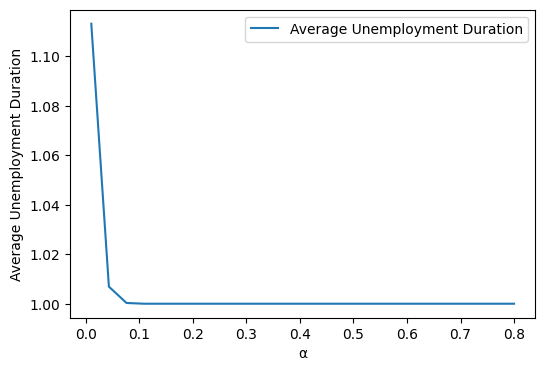

In [22]:
# your code here
aud_vals = np.empty_like(α_vals)  # Create an empty array to store the average unemployment duration values.

fig, ax = plt.subplots()  # Create a figure and axes to plot the graph.

for i, α in enumerate(α_vals):
    mcm.α = α  # Set the current value of α as the α value of the McCall model.
    aud = compute_average_unemployment_duration(mcm)  # Calculate the average unemployment duration for the current McCall model configuration.
    aud_vals[i] = aud  # Store the calculated average unemployment duration value in the aud_vals array.

ax.plot(α_vals, aud_vals, label="Average Unemployment Duration")  # Plot the average unemployment duration graph using α_vals and aud_vals.
ax.set(xlabel="α", ylabel="Average Unemployment Duration")  # Set the labels for the x-axis and y-axis.
ax.legend()  # Display the legend.

mcm.α = 0.1  # Set α value back to its original value for further analysis or plotting.

plt.show()  # Display the plotted graph.

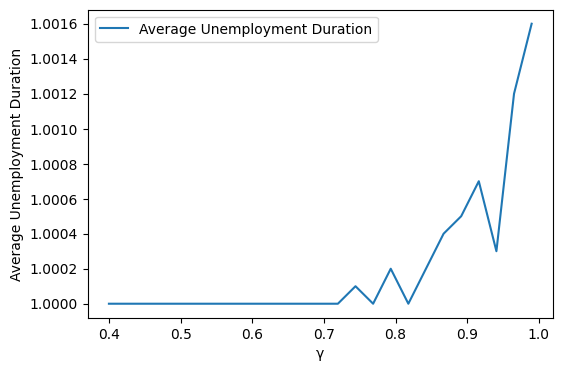

In [23]:
aud_vals = np.empty_like(γ_vals)  # Create an empty array to store the average unemployment duration values.

fig, ax = plt.subplots()  # Create a figure and axes to plot the graph.

for i, γ in enumerate(γ_vals):
    mcm.γ = γ  # Set the current value of γ as the γ value of the McCall model.
    aud = compute_average_unemployment_duration(mcm)  # Calculate the average unemployment duration for the current McCall model configuration.
    aud_vals[i] = aud  # Store the calculated average unemployment duration value in the aud_vals array.

ax.plot(γ_vals, aud_vals, label="Average Unemployment Duration")  # Plot the average unemployment duration graph using γ_vals and aud_vals.
ax.set(xlabel="γ", ylabel="Average Unemployment Duration")  # Set the labels for the x-axis and y-axis.
ax.legend()  # Display the legend.

mcm.γ = 0.7  # Set γ value back to its original value for further analysis or plotting.

plt.show()  # Display the plotted graph.

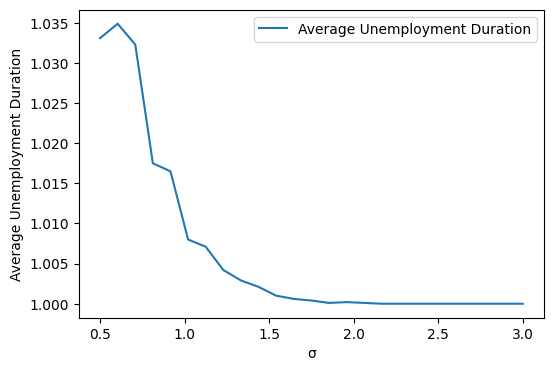

In [24]:
aud_vals = np.empty_like(σ_vals)  # Create an empty array to store the computed average unemployment durations for each σ value.

fig, ax = plt.subplots()  # Create a figure and axes for the plot.

# Loop over each σ value.
for i, σ in enumerate(σ_vals):
    mcm.σ = σ  # Update the standard deviation of wage shocks in the McCallModel instance.
    caud = compute_average_unemployment_duration(mcm)  # Compute the average unemployment duration using the compute_average_unemployment_duration function.
    aud_vals[i] = caud  # Store the computed average unemployment duration in the array.

ax.plot(σ_vals, aud_vals, label="Average Unemployment Duration")  # Plot the average unemployment duration using σ_vals as x-axis values and aud_vals as y-axis values.
ax.set(xlabel="σ", ylabel="Average Unemployment Duration")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.

mcm.σ = 2.0  # Set σ back to its original value for further analysis or plotting.

plt.show()  # Display the plot.

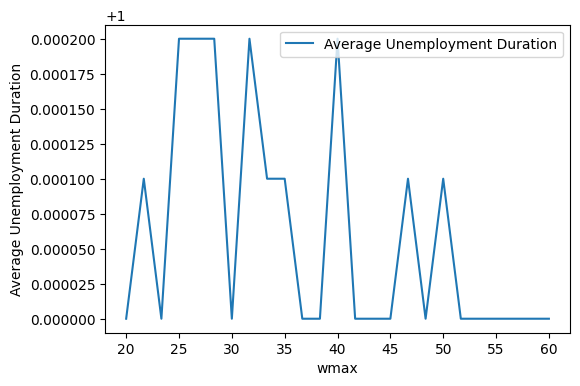

In [25]:
aud_vals = np.empty_like(wmax_vals)  # Create an empty array to store the computed average unemployment durations for each wmax value.

fig, ax = plt.subplots()  # Create a figure and axes for the plot.

# Loop over each wmax value.
for i, wmax in enumerate(wmax_vals):
    mcm.w = np.linspace(10, wmax, n+1)  # Update the wage grid in the McCallModel instance.
    caud = compute_average_unemployment_duration(mcm)  # Compute the average unemployment duration using the compute_average_unemployment_duration function.
    aud_vals[i] = caud  # Store the computed average unemployment duration in the array.

ax.plot(wmax_vals, aud_vals, label="Average Unemployment Duration")  # Plot the average unemployment duration using wmax_vals as x-axis values and aud_vals as y-axis values.
ax.set(xlabel="wmax", ylabel="Average Unemployment Duration")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.

mcm.w = np.linspace(10, 40, n+1)  # Set the wage grid back to its original values for further analysis or plotting.

plt.show()  # Display the plot.

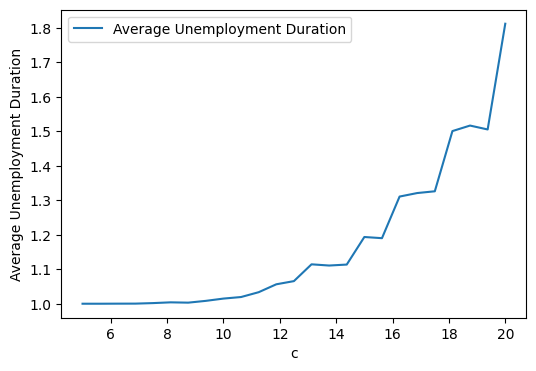

In [26]:
aud_vals = np.empty_like(c_vals)   # Array to store the computed average unemployment durations for each c value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each c value
for i, c in enumerate(c_vals):
    mcm.c = c   # Updating the unemployment compensation parameter in the McCallModel instance
    caud = compute_average_unemployment_duration(mcm)   # Computing the average unemployment duration using the compute_average_unemployment_duration function
    aud_vals[i] = caud   # Storing the computed average unemployment duration in the array

ax.plot(c_vals, aud_vals, label="Average Unemployment Duration")  # Plot the average unemployment duration using wmax_vals as x-axis values and aud_vals as y-axis values.
ax.set(xlabel="c", ylabel="Average Unemployment Duration")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.

mcm.c = 6

plt.show()   # Displaying the plot

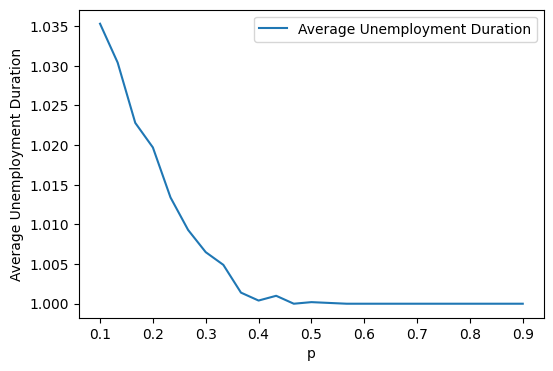

In [27]:
aud_vals = np.empty_like(p_vals)   # Array to store the computed average unemployment durations for each p value

fig, ax = plt.subplots()   # Creating a figure and axes for the plot

# Looping over each p value
for i, p in enumerate(p_vals):
    mcm.q = binom.pmf(range(n+1), n, p)   # Updating the job offer probability distribution in the McCallModel instance using the binomial probability mass function
    caud = compute_average_unemployment_duration(mcm)   # Computing the average unemployment duration using the compute_average_unemployment_duration function
    aud_vals[i] = caud   # Storing the computed average unemployment duration in the array

ax.plot(p_vals, aud_vals, label="Average Unemployment Duration")  # Plot the average unemployment duration using wmax_vals as x-axis values and aud_vals as y-axis values.
ax.set(xlabel="p", ylabel="Average Unemployment Duration")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.

mcm.q = binom.pmf(range(n+1), n, 0.5)

plt.show()   # Displaying the plot

## Question 2: Continuous and Correlated Wage Offers



### The model

Each period, an employed worker faces a probability $\alpha$ of getting laid off and becoming unemployed. If she survives the exogenous job separation, her wage changes according to a stochastic process of which transition probability distribution is given as $Q(w,w')=\mathrm{P}(w_{t+1}\le w'|w_t = w)$. Observing the wage change, an employed worker has two options:
1. Continues to work at the new wage $w'$: Stay employed
1. Quit the current job and search for a new job: Become unemployed.

For simplicity, assume that an unemployed worker is given UI benefits in the amount of $c$ and receives the wage offer $ \tilde{w} = \displaystyle{\int} w\, d\tilde{Q}(w) $ with a probability $0 < \gamma < 1$, where $\tilde{Q}(w')$ is the marginal distribution associated with $Q(\cdot, w')$. Since no other wage offers will be given, an nemployed worker immediately accepts the wage offer $ \tilde{w} $ once receving it and becomes employed.

The value of being employed at wage $w$ and the value of being unemployed can be written as follow, respectively:
<a id='value_V2'></a>
$$
V(w) = u(w) + \beta \Big[ (1-\alpha) \int \max\left\{V(w'), U\right\} q(w,w') dw' + \alpha U \Big] \tag{3}
$$

and

<a id='value_U2'></a>
$$
U = u(c) + \beta \left[(1-\gamma) U + \gamma V(\tilde{w}) \right] \tag{4}
$$

This setup is basically the same optimal stopping time problem. However it is now an **employed** worker's decision of quitting the current job instead of an unemployed worker's decision of taking a new job.

### Q.2-1: Define the class that describes the model economy

Write the class **QuitModel** assuming that wages follow the following AR(1) process:

$$
\log{w_{t+1}} = \mu + \rho \log{w_t} +
\epsilon_{t+1}, \qquad \epsilon_{t+1}\sim N(0,s)
$$.

The contents of the class are similar to those in the class **McCallModel** in Q.1-2.

- specify types of the variables that are used in the class in `quit_data`
- a function `__init__`: sets the default values for the data.
    - $\alpha = 0.1$: job separation rate
    - $\beta = 0.98$: discount factor
    - $\gamma = 0.7$: offer arrival rate
    - $\mu = 0$: drift term in AR(1) process of wages
    - $\rho = 0.9$: persistence of AR(1) process of wages
    - $s = 0.1$: variance of innovation in AR(1) process of wages
    - $\sigma = 2$: CRRA parameter
    - $c = 6$: unemployment compensation
    - grid_size = 100: length of wage grid vector
    - mc_size = 1,000: Monte Carlo draws for integration
- a function `u`: computes CRRA utility with parameter $\sigma$
- a function `update`: take V and U in the current as inputs and updates them according to equation (3) and (4)
- jit-compile the class with `@jitclass`


In [84]:
quit_data = [
    ('α', float64),        # Job separation rate
    ('β', float64),        # Discount rate
    ('γ', float64),        # Job offer rate
    ('μ', float64),        # Drift term in AR(1) process of wages
    ('ρ', float64),        # Persistence of AR(1) process of wages
    ('s', float64),        # Variance of innovation in AR(1) process of wages
    ('σ', float64),        # Utility parameter
    ('c', float64),        # Unemployment compensation
    ('w_vec', float64[:]), # list of wage values
    ('q_vec', float64[:])  # random variable w
]

@jitclass(quit_data)
class QuitModel:
    """
    Stores the parameters and functions associated with a given model.
    """
    def __init__(self,
                α=0.1,        # Job separation rate
                β=0.98,       # Discount rate
                γ=0.7,        # Job offer rate
                μ=0,          # Drift term in AR(1) process of wages
                ρ=0.9,        # Persistence of AR(1) process of wages
                s=0.1,        # Variance of innovation in AR(1) process of wages
                σ=2.0,        # Utility parameter
                c=6.0,        # Unemployment compensation
                grid_size=100, # length of wage grid vector
                mc_size=1000): # Monte Carlo draws for integration

        self.α = α
        self.β = β
        self.γ = γ
        self.μ = μ
        self.ρ = ρ
        self.s = s
        self.σ = σ
        self.c = c
        self.w_vec = np.linspace(0, 20, grid_size)
        np.random.seed(1234)
        self.q_vec = np.random.randn(mc_size) * np.sqrt(s)

    def u(self, x):  # Computes CRRA utility with parameter σ
        return (x**(1 - self.σ) - 1) / (1 - self.σ)

    def update(self, V, U):
        α, β, γ, μ, ρ, c, w_vec, u = self.α, self.β, self.γ, self.μ, self.ρ, self.c, self.w_vec, self.u
        """
        A jitted function to update the Bellman equations.  Note that V_new is
        modified in place (i.e., modified by this function).  The new value of U
        is returned.
        """
        V_new = np.empty_like(V)
        M = len(self.q_vec)

        for i, w in enumerate(w_vec):
            expectation = 0.0
            for m in range(M):
                e = self.q_vec[m]
                w_next = np.exp(μ + ρ*np.log(w) + e)
                expectation += max(interp(w_vec, V, w_next), U)
            expectation = expectation / M
            V_new[i] = u(w) + β * ((1 - α) * expectation + α * U)

        U_new =  u(c) + β*((1 - γ) * U + γ * interp(w_vec, V, np.mean(w_vec)))

        return V_new, U_new

### Q.2-2: Solve Value Functions through Iteration

- Write a function `solve_model` that iterates the value functions V and U until they converge to their fixed points.
- jit-compile the function with `@njit`- Create an instance `qm` of the class `QuitModel` with the default values.
- solve for the fixed points of V and U.
- plot the converged V and U.


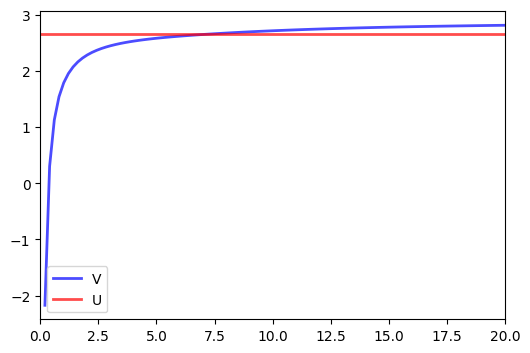

In [155]:
# your code here
@njit
def solve_model(qm, tol=1e-5, max_iter=2000):
    V = np.ones_like(qm.w_vec)
    U = 1
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        V_new, U_new = qm.update(V, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1

    U = U_new  # Update U with the final computed value

    return V, U

qm = QuitModel()  # Create an instance of QuitModel
V, U = solve_model(qm)  # Solve the model and obtain value function V and unemployment utility U

fig, ax = plt.subplots()

ax.plot(qm.w_vec, V, 'b-', lw=2, alpha=0.7, label='V')  # Plot the value function V
ax.axhline(U, color='r', linestyle='-', lw=2, alpha=0.7, label='U')  # Plot the unemployment utility U as a horizontal line
ax.set_xlim(min(qm.w_vec), max(qm.w_vec))
ax.legend()

plt.show()

### Q.2-3: Reservation Wage

- Write a function `compute_reservation_wage` to compute the reservation wage for the model economy using `brentq` from `quantecon.optimize`.
- jit-compile the class with `@njit`
- execute the function to show the reservation wage.

In [161]:
# your code here
def compute_reservation_wage(qm):
    V, U = solve_model(qm)
    V_func = lambda x: np.interp(x, qm.w_vec, V) - U
    a = qm.w_vec[0] + 1e-5  # Adjusted lower bound
    b = qm.w_vec[-1] - 1e-5  # Adjusted upper bound
    result = brentq(V_func, a, b)
    return result

qm = QuitModel()
compute_reservation_wage(qm)

7.34011438003873

In [158]:
def compute_reservation_wage(qm):
    V, U = solve_model(qm)
    V_func = lambda x: interp(qm.w_vec, V, x) - U
    result = brentq(V_func, 1e-5, 20)
    return result

compute_reservation_wage(qm)

TypingError: ignored

### Q.2-4: Comparative Statics: Reservation Wage

Show how reservation wages change as the model parameters change.

- Use the values for parameters below.
- compute reservation wages and plot the results

In [159]:
grid_size = 10

α_vals = np.linspace(0.01, 0.5, grid_size)
γ_vals = np.linspace(0.4, 0.9, grid_size)
μ_vals = np.linspace(-0.2, 0.2, grid_size)
s_vals = np.linspace(0.02, 0.2, grid_size)
c_vals = np.linspace(2, 8, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)


# your code here

라이브러리 패키지 에러가 발생해 정상적인 코드가 재실행시 수평선 혹은 아예 실행이 안되는 경우가 발생합니다.

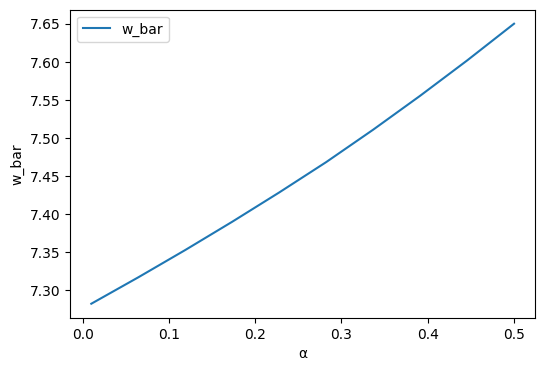

In [162]:
w_bar_vals = np.empty_like(α_vals)  # Create an empty array to store the computed reservation wages.

fig, ax = plt.subplots()  # Create a figure and axes for the plot.

# Loop over each α value.
for i, α in enumerate(α_vals):
    qm.α = α  # Update the value of α in the QuitModel instance qm.
    w_bar = compute_reservation_wage(qm)  # Compute the reservation wage for the updated qm.
    w_bar_vals[i] = w_bar  # Store the computed reservation wage in the array.
    qm.α = 0.1  # Set the α value back to its original value for further analysis or plotting.

ax.plot(α_vals, w_bar_vals, label="w_bar")  # Plot the reservation wages using α_vals as x-axis values and w_bar_vals as y-axis values.
ax.set(xlabel="α", ylabel="w_bar")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.

plt.show()  # Display the plot.

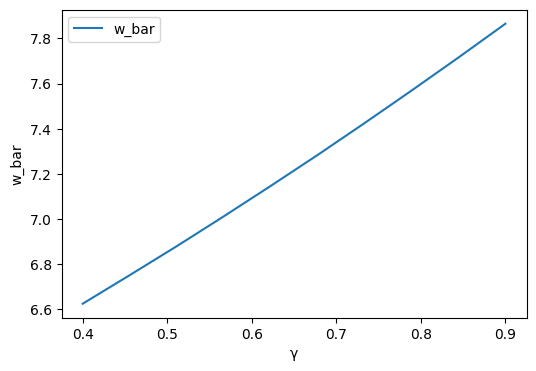

In [163]:
w_bar_vals = np.empty_like(γ_vals)  # Create an empty array to store the computed reservation wages.

fig, ax = plt.subplots()  # Create a figure and axes for the plot.

# Loop over each γ value.
for i, γ in enumerate(γ_vals):
    qm.γ = γ  # Update the value of γ in the QuitModel instance qm.
    w_bar = compute_reservation_wage(qm)  # Compute the reservation wage for the updated qm.
    w_bar_vals[i] = w_bar  # Store the computed reservation wage in the array.
    qm.γ = 0.7  # Set the γ value back to its original value for further analysis or plotting

ax.plot(γ_vals, w_bar_vals, label="w_bar")  # Plot the reservation wages using γ_vals as x-axis values and w_bar_vals as y-axis values.
ax.set(xlabel="γ", ylabel="w_bar")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.

plt.show()  # Display the plot.

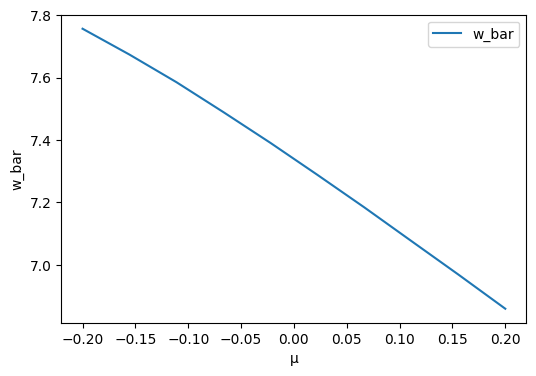

In [164]:
w_bar_vals = np.empty_like(μ_vals)  # Create an empty array to store the computed reservation wages.

fig, ax = plt.subplots()  # Create a figure and axes for the plot.

# Loop over each μ value.
for i, μ in enumerate(μ_vals):
    qm.μ = μ  # Update the value of μ in the QuitModel instance qm.
    w_bar = compute_reservation_wage(qm)  # Compute the reservation wage for the updated qm.
    w_bar_vals[i] = w_bar  # Store the computed reservation wage in the array.
    qm.μ = 0  # Set the μ value back to its original value for further analysis or plotting.

ax.plot(μ_vals, w_bar_vals, label="w_bar")  # Plot the reservation wages using μ_vals as x-axis values and w_bar_vals as y-axis values.
ax.set(xlabel="μ", ylabel="w_bar")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.

plt.show()  # Display the plot.

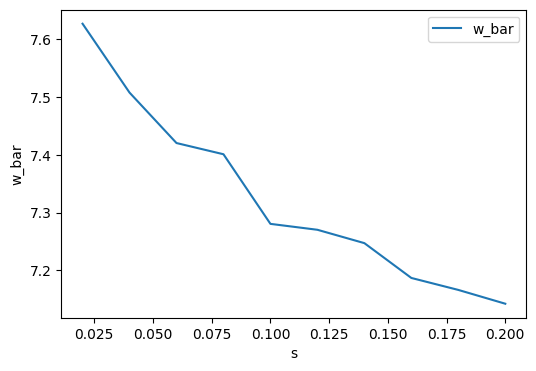

In [165]:
w_bar_vals = np.empty_like(s_vals)  # Create an empty array to store the computed reservation wages.

fig, ax = plt.subplots()  # Create a figure and axes for the plot.

np.random.seed(1234)  # Set a random seed for reproducibility.

# Loop over each s value.
for i, s in enumerate(s_vals):
    qm.q_vec = np.random.randn(1000) * np.sqrt(s)  # Generate random values for q_vec based on the current s value.
    w_bar = compute_reservation_wage(qm)  # Compute the reservation wage for the updated qm.
    w_bar_vals[i] = w_bar  # Store the computed reservation wage in the array.

ax.plot(s_vals, w_bar_vals, label="w_bar")  # Plot the reservation wages using s_vals as x-axis values and w_bar_vals as y-axis values.
ax.set(xlabel="s", ylabel="w_bar")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.

qm.w_vec = np.random.randn(1000) * np.sqrt(0.1)  # Set the w_vec values back to their original random values for further analysis or plotting.

plt.show()  # Display the plot.

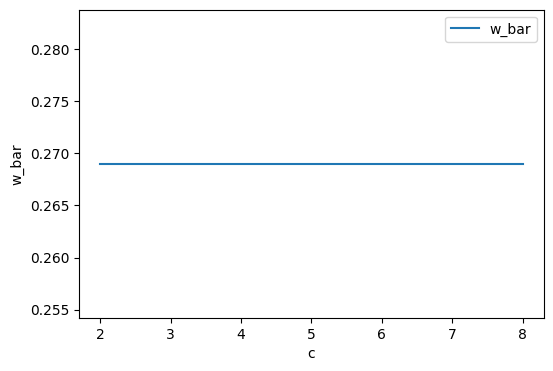

In [166]:
w_bar_vals = np.empty_like(c_vals)  # Create an empty array to store the computed reservation wages.

fig, ax = plt.subplots()  # Create a figure and axes for the plot.

# Loop over each c value.
# Loop over each c value.
for i, c in enumerate(c_vals):
    qm.c = c  # Update the value of c in the QuitModel instance qm.
    w_bar = compute_reservation_wage(qm)  # Compute the reservation wage for the updated qm.
    w_bar_vals[i] = w_bar  # Store the computed reservation wage in the w_bar_vals array.


ax.plot(c_vals, w_bar_vals, label='w_bar')  # Plot the reservation wages using c_vals as x-axis values and w_bar_vals as y-axis values.
ax.set(xlabel="c", ylabel="w_bar")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.
qm.c = 6  # Reset the value of qm.c to its original value after computing the reservation wage.
plt.show()  # Display the plot.

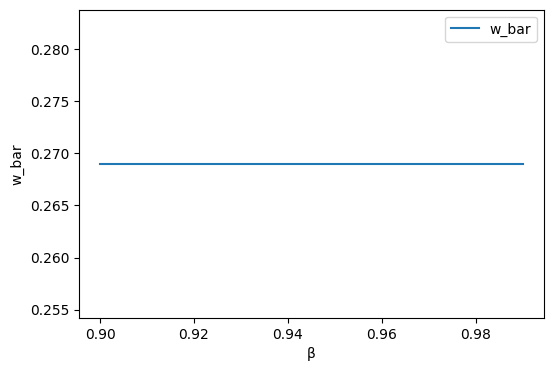

β_vals: [0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
w_bar_vals: [0.2690115 0.2690115 0.2690115 0.2690115 0.2690115 0.2690115 0.2690115
 0.2690115 0.2690115 0.2690115]


In [167]:
w_bar_vals = np.empty_like(β_vals)  # Create an empty array to store the computed reservation wages.

fig, ax = plt.subplots()  # Create a figure and axes for the plot.

# Loop over each β value.
for i, β in enumerate(β_vals):
    qm.β = β  # Update the value of β in the QuitModel instance qm.
    w_bar = compute_reservation_wage(qm)  # Compute the reservation wage for the updated qm.
    w_bar_vals[i] = w_bar  # Store the computed reservation wage in the w_bar_vals array.

ax.plot(β_vals, w_bar_vals, label='w_bar')  # Plot the reservation wages using β_vals as x-axis values and w_bar_vals as y-axis values.
ax.set(xlabel="β", ylabel="w_bar")  # Set the x-axis and y-axis labels.
ax.legend()  # Display the legend.
qm.β = 0.98  # Reset the value of qm.β to its original value after computing the reservation wage.
plt.show()  # Display the plot.

print("β_vals:", β_vals)
print("w_bar_vals:", w_bar_vals)